<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/NLP-Projects/blob/main/Fake-News%20Classification%20Using%20LSTM/Fake_News_Classification_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Enviorment

In [10]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle competitions download -c fake-news
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


# Import Libraries

In [80]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                    LSTM,
                                    Embedding,
                                    Dropout,
                                    Bidirectional)
from tensorflow.keras.regularizers  import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [21]:
# ======================== #
# Setup Preprocessing
# ======================== #

nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Import & Analyze the Dataset

In [16]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [17]:
# ===================== #
# Analyze DataFrame
# ===================== #

def analyze_df(df, dataset_name, display_head=True, summary_stats=True):
    """
    Analyzes a given DataFrame and prints useful information about it.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        dataset_name (str): Name of the dataset for display purposes.
        display_head (bool): If True, display the first few rows of the DataFrame.
        summary_stats (bool): If True, include summary statistics for numeric columns.

    Returns:
        None
    """
    # DataFrame Analysis
    print(f"{'-'*40}\nAnalyzing '{dataset_name}' DataFrame\n{'-'*40}\n")
    print(f"Number of Rows: {df.shape[0]} | Number of Columns: {df.shape[1]}")
    print("\nColumn Overview:")
    print(df.info())

    # Check Missing Values
    print(f"\n{'-'*40}\n Missing Values \n{'-'*40}\n")
    print("Missing Values: ")
    nans = df.isna().sum()
    if nans.sum() > 0:
        print(nans[nans > 0])
    else:
        print("No Missing Values...")

    # Check Dupes
    print(f"\n{'-'*40}\n Duplicated Rows \n{'-'*40}\n")
    dupes = df.duplicated().sum()
    print(f"Number of Duplicates: {dupes}")

    # Statistical Analysis
    print(f"\n{'-'*40}\n {dataset_name} Statistical Summary \n{'-'*40}\n")
    if summary_stats:
        print("Summary Statistics:")
        print(df.describe())

    if display_head:
        print(f"\n{'-'*40}\n DataFrame Sample \n{'-'*40}\n")
        print("\nFirst Few Rows:")
        return df.head()

    print(f"\n{'-'*40}\nAnalysis Complete for '{dataset_name}'\n{'-'*40}")

In [18]:
# ======================== #
# Analyze Train Dataframe
# ======================== #
analyze_df(train_df, "Train")

----------------------------------------
Analyzing 'Train' DataFrame
----------------------------------------

Number of Rows: 20800 | Number of Columns: 5

Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None

----------------------------------------
 Missing Values 
----------------------------------------

Missing Values: 
title      558
author    1957
text        39
dtype: int64

----------------------------------------
 Duplicated Rows 
----------------------------------------

Number of Duplicates: 0

----------------------------------------
 Train Statistical Summary 
-------------------------------------

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [19]:
# ======================== #
# Analyze Test Dataframe
# ======================== #

analyze_df(test_df, "Test")

----------------------------------------
Analyzing 'Test' DataFrame
----------------------------------------

Number of Rows: 5200 | Number of Columns: 4

Column Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB
None

----------------------------------------
 Missing Values 
----------------------------------------

Missing Values: 
title     122
author    503
text        7
dtype: int64

----------------------------------------
 Duplicated Rows 
----------------------------------------

Number of Duplicates: 0

----------------------------------------
 Test Statistical Summary 
----------------------------------------

Summary Statistics:
                 id

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


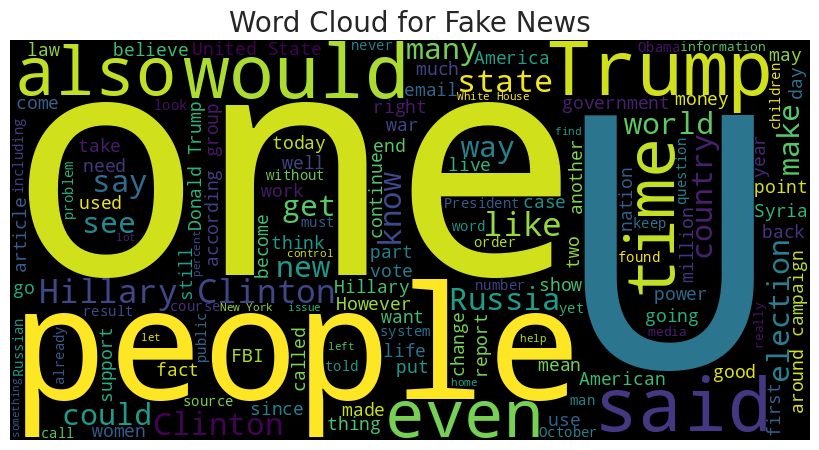

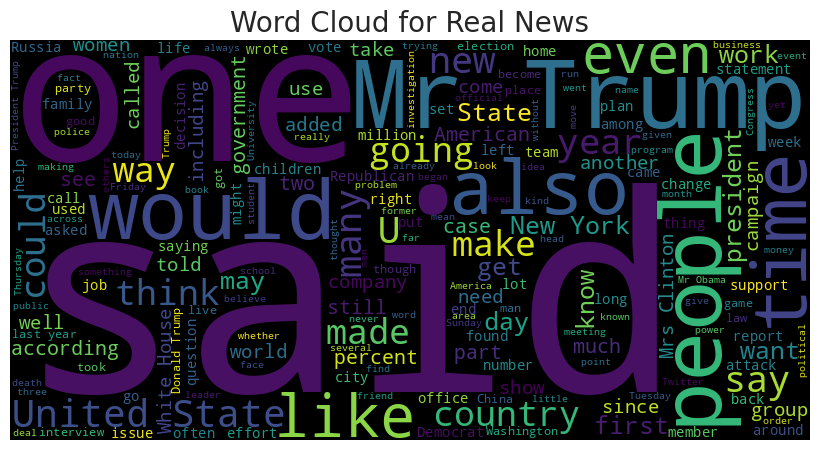

In [26]:
# ======================== #
# WordCloud Train Dataset
# ======================== #

# FAKE NEWS
fake_news = " ".join(train_df[train_df['label'] == 1]['text'].astype(str).tolist())
real_news = " ".join(train_df[train_df['label'] == 0]['text'].astype(str).tolist())

# Create a wordcloud
wordcloud_fake = WordCloud(width = 800, height = 400,
                           background_color='black', stopwords=set(stopwords.words('english')),
                           min_font_size=10).generate(fake_news)
# Plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_fake)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud for Fake News", fontsize=20)
plt.show()

# ================================================ #
# ================================================ #

# REAL NEWS
fake_news = " ".join(train_df[train_df['label'] == 1]['text'].astype(str).tolist())
real_news = " ".join(train_df[train_df['label'] == 0]['text'].astype(str).tolist())

# Create a wordcloud
wordcloud_fake = WordCloud(width = 800, height = 400,
                           background_color='black', stopwords=set(stopwords.words('english')),
                           min_font_size=10).generate(real_news)
# Plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_fake)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word Cloud for Real News", fontsize=20)
plt.show()


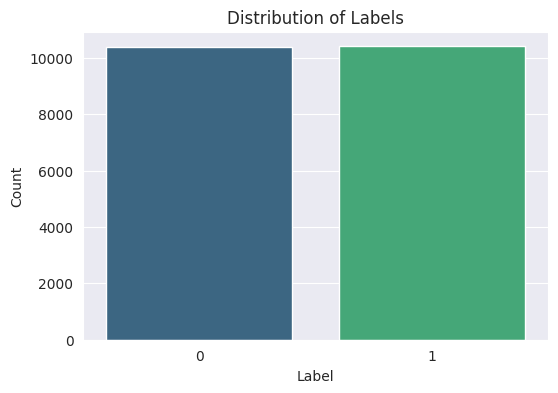

In [23]:
# ======================== #
# Countplot Of Label
# ======================== #

plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(x='label', data=train_df, palette='viridis')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Data Preparation

### Text-Preprocessing

In [24]:
def text_preprocessing(text):
    """
    Preprocesses the given text:
    - Converts to lowercase
    - Removes non-alphabetic characters
    - Tokenizes the text
    - Removes stopwords
    - Lemmatizes the words

    Parameters:
        text (str): Input text to preprocess.

    Returns:
        str: Preprocessed text.
    """
    # Handle non-string inputs
    if not isinstance(text, str):
        return ""

    text = text.lower() # Convert text to lower
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove non-alphabetic characters
    words = word_tokenize(text) # Tokenize the text
    words = [word for word in words if word not in stopwords.words('english')] # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words] # Lemmatization
    return " ".join(words) # Joing words

In [25]:
# ======================== #
# Apply Preprocssing Func
# ======================== #

# Train Dataframe
train_df['preprocessed_text'] = train_df['text'].apply(text_preprocessing)
# Test Dataframe
test_df['preprocessed_text'] = test_df['text'].apply(text_preprocessing)

### Tokenization

In [28]:
# ======================== #
# Tokenization & Padding
# ======================== #
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['preprocessed_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['preprocessed_text'])

max_length=100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [29]:
# Seperate Labels
train_labels = train_df['label'].values

# Define Model

In [33]:
# Split train/Test sets
X_train, X_test, y_train, y_test = train_test_split(train_padded, train_labels,
                                                    test_size=0.2, random_state=42)


In [37]:
print(f"X Train Shape: ", X_train.shape)
print(f"X Test Shape: ", X_test.shape)
print(f"Y Train Shape: ", y_train.shape)
print(f"Y Test Shape: ", y_test.shape)

X Train Shape:  (16640, 100)
X Test Shape:  (4160, 100)
Y Train Shape:  (16640,)
Y Test Shape:  (4160,)


In [58]:
# ================= #
# Build The Model
# ================= #

model = Sequential([
    # Embedding Layer
    Embedding(input_dim=10000, output_dim=128,
              input_length=max_length),
    # LSTM
    Bidirectional(LSTM(256,
         return_sequences=False,
         recurrent_regularizer=l2(0.01),
         bias_regularizer=l2(0.01))),

    Dropout(0.2),

    # FC layer
    Dense(64, activation='relu',
          kernel_regularizer=l2(0.01)),
    Dropout(0.2),

    # Output layer
    Dense(1,
          activation='sigmoid')

])

In [64]:
# Explicitly build the model
model.build(input_shape=(None, max_length))

# Compile Model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 512)                 │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,101,377 (8.02 MB)

 Trainable params: 2,101,377 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# ================= #
# Callbacks
# ================= #

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
check_point = ModelCheckpoint(
    filepath='/content/best_model.h5.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [65]:
# ================= #
# Train The Model
# ================= #

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, check_point]
)

Epoch 1/10
413/416 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9983 - loss: 0.0226
Epoch 1: val_loss improved from inf to 0.43388, saving model to /content/best_model.h5.keras
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9983 - loss: 0.0227 - val_accuracy: 0.9153 - val_loss: 0.4339
Epoch 2/10
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9993 - loss: 0.0147
Epoch 2: val_loss improved from 0.43388 to 0.42876, saving model to /content/best_model.h5.keras
416/416 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9993 - loss: 0.0148 - val_accuracy: 0.8936 - val_loss: 0.4288
Epoch 3/10
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9976 - loss: 0.0273
Epoch 3: val_loss did not improve from 0.42876
416/416 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9976 - loss: 0.0273 - val_accuracy: 0.8810 - val_loss: 0.5871
Epoch 4/10
414/416 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9979 - loss: 0.0326
Epoch 4: val_loss improved from 0.42876 to 0.42121, saving 

In [66]:
# =================== #
# Evaluate The Model
# =================== #

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9017 - loss: 0.4442
Test Loss: 0.4341941773891449, Test Accuracy: 0.9033653736114502


In [67]:
# =================== #
# Evaluate The Model
# =================== #

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2132
           1       0.90      0.91      0.90      2028

    accuracy                           0.90      4160
   macro avg       0.90      0.90      0.90      4160
weighted avg       0.90      0.90      0.90      4160

[[1916  216]
 [ 186 1842]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC: 0.9643639377051485


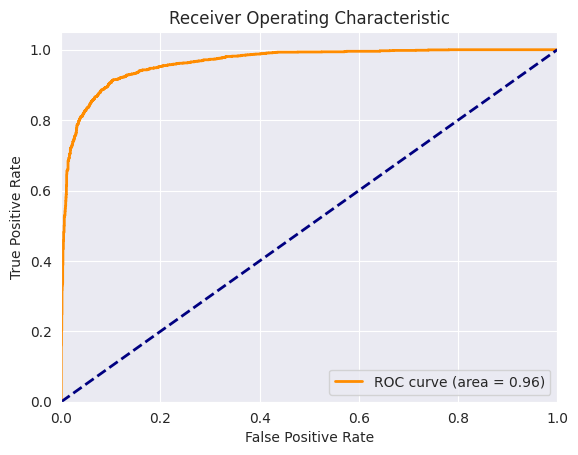

In [81]:
# =================== #
# ROC AUC Curve
# =================== #

# Get predicted probabilities
y_probs = model.predict(X_test)

# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot the ROC curve as well to visualize the trade-off
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Test Model on `test_df`

In [68]:
# =================== #
# Load Saved Model
# =================== #

model = load_model('/content/best_model.h5.keras')

<Sequential name=sequential_4, built=True>

In [71]:
# ====================== #
# Preprocessing test_df
# ====================== #

test_df['preprocessed_text'] = test_df['text'].apply(text_preprocessing)

# Tokenize the text and pad sequences
X_test_df = tokenizer.texts_to_sequences(test_df['preprocessed_text'])
X_test_df = pad_sequences(X_test_df, maxlen=max_length)

In [73]:
# ========================== #
# Make Prediction On Test_df
# ========================== #

predictions = model.predict(X_test_df)

# Convert probabilities to class labels (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Add predictions to the test_df
test_df['predictions'] = predictions

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [74]:
test_df['predictions']

,predictions
0,0
1,1
2,1
3,0
4,1
...,...
5195,0
5196,0
5197,0
5198,0


# Save Pickle File

In [77]:
import pickle

# Save model architecture and weights into a pickle file
with open('fake_news_lstm_model.pkl', 'wb') as f:
    pickle.dump(model, f)